In [1]:
import cv2
import numpy as np
%pylab inline
import matplotlib.pyplot as plt
import itertools as itertools 
import time
import os
import pandas as pd
import scipy.spatial as scipy_spatial
from skimage import color
import pickle
import sklearn

Populating the interactive namespace from numpy and matplotlib


In [2]:
img_save_dir = 'D:\\1920Sem1\\CS4243\\project_wx_tryout_code\\rectangles'

image_dir = "D:\\1920Sem1\CS4243\project\CS4243-Project\datasets\JPEGImages"
images = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, img))]

In [3]:
def preprocess_input_img(img_0):
    hsv = cv2.cvtColor(img_0, cv2.COLOR_RGB2HSV)

    lower_red = np.array([110,80,80])
    upper_red = np.array([160,255,255])
    mask_red_only = cv2.inRange(hsv, lower_red, upper_red)

    lower_white = np.array([0,0,255])
    upper_white = np.array([255,255,255])
    mask_white_only = cv2.inRange(hsv, lower_white, upper_white)
    
    # attach a column of row number to the masks
    index_array = np.flip(np.arange(mask_red_only.shape[1]))

    stacked_red = np.vstack((index_array, mask_red_only))
    stacked_red_white = np.vstack((stacked_red, mask_white_only))

    red_mask_rot = np.rot90(stacked_red)
    red_white_mask_rot = np.rot90(stacked_red_white)
    
    return red_white_mask_rot

In [4]:
def get_suspected_waldo_stripe_region_for_col(red_white_mask_col, ratio_range=(1/2, 2), white_pixel_threshold=0.15):
    col_index = red_white_mask_col[0]
    red_mask_col = red_white_mask_col[1:int((len(red_white_mask_col)-1)/2+1)]
    white_mask_col = red_white_mask_col[int((len(red_white_mask_col)-1)/2+1):]
    assert red_mask_col.shape == white_mask_col.shape, "the mask column inputs for white and red masks are of different shapes:" + str(red_mask_col.shape) + "; " + str(white_mask_col.shape)
    
    
    white_mask_col = white_mask_col[1:]
    
    new_red_mask_col = np.zeros(len(red_mask_col))
    new_red_mask_col[red_mask_col == 255] = 1
    new_red_mask_col[red_mask_col == 0] = -1
    
    new_white_mask_col = np.zeros(len(white_mask_col))
    new_white_mask_col[white_mask_col == 255] = 1
    new_white_mask_col[white_mask_col == 0] = 0

    streak_array = get_streak_len_array_with_approx(new_red_mask_col, 0)
    ratio_array = np.array([abs(streak_array[i]) / abs(streak_array[i + 1]) for i in range(len(streak_array) - 1)])
    accepted_ratio_indice, = np.where(np.logical_and(ratio_array > ratio_range[0], ratio_array < ratio_range[1]))
    is_accepted_ratio_indice_continuous, lst_of_start_and_end = is_indice_continuous(accepted_ratio_indice)

    revised_lst_of_start_and_end = []

    if is_accepted_ratio_indice_continuous:
        # then check if the negative pixels are white pixels
        for start, end in lst_of_start_and_end:
            is_region_start_with_red = streak_array[start+2] > 0
            offset = 0
            if is_region_start_with_red:
                offset = 1
            
            total_number_of_white_pixels = 0
            total_number_of_non_red_pixels = 0
#             region = [np.sum(np.abs(streak_array[:accepted_ratio_indice[start]])), np.sum(np.abs(streak_array[:accepted_ratio_indice[end-1]+1]))]
#             print("start, end: " + str(region[0]) + ", " + str(region[1]))

            while start + offset < end:
                supposedly_white_pixel_region = [np.sum(np.abs(streak_array[:accepted_ratio_indice[start + offset]])), np.sum(np.abs(streak_array[:accepted_ratio_indice[start + offset]+1]))]

                number_of_white_pixels = np.sum(new_white_mask_col[int(supposedly_white_pixel_region[0]) : int(supposedly_white_pixel_region[1])])
                number_of_non_red_pixels = supposedly_white_pixel_region[1] - supposedly_white_pixel_region[0]

                total_number_of_white_pixels += number_of_white_pixels
                total_number_of_non_red_pixels += number_of_non_red_pixels
                offset += 2

            if total_number_of_white_pixels / total_number_of_non_red_pixels > white_pixel_threshold:
                revised_lst_of_start_and_end.append((start, end))
        
        if len(revised_lst_of_start_and_end) == 0:
            empty_terms = np.array(list(itertools.repeat([int(False), col_index, -1, -1, 0, 0], 20)))
            return empty_terms
        stripe_region = [[int(True), \
                          col_index, \
                          np.sum(np.abs(streak_array[:accepted_ratio_indice[start]])), \
                          np.sum(np.abs(streak_array[:accepted_ratio_indice[end-1]+1])), \
                          int(end - start), \
                          (np.sum(np.abs(streak_array[:accepted_ratio_indice[end-1]+1])) - np.sum(np.abs(streak_array[:accepted_ratio_indice[start]]))) / int(end - start)] \
                         for start, end in revised_lst_of_start_and_end]
        # from here examine the percentage of white pixels in the region
        # if there are white pixels dominating the negative pixels, then it is stripes
        # return (1, col_number, start_of_stripe_region, end_of_stripe_region, number_of_stripes, average_width_of_stripes)        
        how_many_more_terms = 20 - len(stripe_region)
        additional_terms = np.array(list(itertools.repeat([int(False), col_index, -1, -1, 0, 0], how_many_more_terms)))
        return np.vstack((stripe_region, additional_terms))    

    empty_terms = np.array(list(itertools.repeat([int(False), col_index, -1, -1, 0, 0], 20)))
    return empty_terms

In [5]:
def get_streak_len_array_with_approx(unit_lst, threshold):
    # in the unit_lst, 1 represents the superior pixel value, -1 is the inferior pixel value
    # the superior pixel value is the one that is well captured in color distillation 
    # in our case e.g. red is the superior pixel value because it is well captured 
    # and white is the inferior pixel value because it might be noise
    # we want to restore the shape outlined by the superior pixel value
    # hence we need to minimize the disturbannce by the inferior pixel value
    # hence we need to remove the 'sparse' inferior pixel value located within the streaks of superior pixel values
    # the definition of sparse is given by the threshold
    previous = 0
    streak_len_array = []
    streak_len = 0
    fast_forward_count = 0
    for i in range(len(unit_lst)):
        if i == 0:
            previous = unit_lst[i]
            
        if fast_forward_count > 0:
            fast_forward_count -= 1
            if i == len(unit_lst) - 1:
                streak_len_array.append(streak_len)
            continue
        
        if previous == unit_lst[i]:
            cur_streak_len = streak_len
            streak_len += unit_lst[i]
            if i == len(unit_lst) - 1:
                streak_len_array.append(streak_len)
            previous = unit_lst[i]
        else:
            if streak_len > 0:
                # superior pixel streak ending
                cur_streak_len = streak_len
                # we need to look ahead the threshold number of pixels to see if theres any superior pixel
                next_few_number = min(threshold, len(unit_lst) - 1 - i)
                next_few_pixels = unit_lst[i : i+1+next_few_number]
                # if there is we will continue the superior pixel streak from there
                indice_of_next_superior_pixel, = np.where(next_few_pixels == 1)
                if len(indice_of_next_superior_pixel) != 0:
                    next_superior = max(indice_of_next_superior_pixel)
                    streak_len += 1 + next_superior
                    fast_forward_count = next_superior
                    previous = abs(unit_lst[i])
                # if not we end the superior pixel streak here and start a new inferior pixel streak
                else:
                    streak_len_array.append(cur_streak_len)
                    streak_len = 0
                    streak_len += unit_lst[i]
                    previous = unit_lst[i]
            elif streak_len < 0:
                # inferior pixel streak ending
                # we will start a new superior pixel streak
                streak_len_array.append(streak_len)
                streak_len = 0
                streak_len += unit_lst[i]
                previous = unit_lst[i]
            
    return streak_len_array

def get_streak_len_array(unit_lst):
    previous = 0
    streak_len_array = []
    streak_len = 0
    for i in range(len(unit_lst)):
        if i == 0:
            previous = unit_lst[i]
        
        if previous == unit_lst[i]:
            streak_len += unit_lst[i]
            if i == len(unit_lst) - 1:
                streak_len_array.append(streak_len)
        else:
            streak_len_array.append(streak_len)
            streak_len = 0
            
        previous = unit_lst[i]
        
    return streak_len_array


# Method: Given a 1D array, find the starting position and the ending position of an arithmatic sequence with the next equal to 1+previous. The sequence must contain no less than 3 numbers.
# Input: a 1D array of integers
# Output: a tuple in the form of (Boolean, list). The boolean is True when there is at least one sequence. The list consists of tuples (starting_position_of_sequence_inclusive, ending_position_of_sequence_exclusive)
def is_indice_continuous(lst_of_indice):
    # right now the number of stripes accepted is 3
    is_continuous = False
    continuous_count = 0
    prev = -1
    start_index = -1
    lst_of_start_and_end = []
    for i in range(len(lst_of_indice)):
        if i == 0:
            prev = lst_of_indice[i]
            start_index = i
            continuous_count = 1
            continue
            
        if lst_of_indice[i] - prev == 1:
            # the streak continues
            continuous_count += 1
        else:
            # the streak ends
            if continuous_count >= 3:
                lst_of_start_and_end.append((start_index, i))
                is_continuous = True

            continuous_count = 1
            start_index = i
            
        if i == len(lst_of_indice) - 1:
            if start_index != -1 and continuous_count >= 3:
                lst_of_start_and_end.append((start_index, i))
                is_continuous = True
        
        prev = lst_of_indice[i]
        
    return (is_continuous, lst_of_start_and_end)

In [6]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

def convert_rot90_col_no_to_original_col_no(rot90_image, col_no):
    return rot90_image.shape[0] - col_no

def convert_original_col_no_to_rot90_col_no(image, col_no):
    return image.shape[1] - col_no

In [7]:
def is_able_to_combine(row1, row2, confidence_area_overlap_ratio_threshold):
    row1_width = row1[3] - row1[2]
    row1_height = row1[5] - row1[4]
    row2_width = row2[3] - row2[2]
    row2_height = row2[5] - row2[4]
    
    bbox1 = (row1[2], row1[4], row1_width, row1_height)
    bbox2 = (row2[2], row2[4], row2_width, row2_height)
    
    iou = IoU(bbox1, bbox2)
    
    if (iou >= confidence_area_overlap_ratio_threshold):
        return True
    else:
        return False
    
def IoU(bbox1, bbox2):
    """ Compute IoU of two bounding boxes

    Args:
        bbox1 - 4-tuple (x, y, w, h) where (x, y) is the top left corner of
            the bounding box, and (w, h) are width and height of the box.
        bbox2 - 4-tuple (x, y, w, h) where (x, y) is the top left corner of
            the bounding box, and (w, h) are width and height of the box.
    Returns:
        score - IoU score
    """
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    score = 0
    ### YOUR CODE HERE
    
    x_left = max(x1, x2)
    y_top = max(y1, y2)
    x_right = min(x1+w1, x2+w2)
    y_bottom = min(y1+h1, y2+h2)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    area1 = w1 * h1
    area2 = w2 * h2
    score = intersection_area / float(area1 + area2 - intersection_area)
    ### END YOUR CODE

    return score

    
def merge_rows(data, row_1_index, row_2_index):
#     ['col_no_original', 'stripe_centre_for_each_col',
#        'col_confidence_interval_start', 'col_confidence_interval_end',
#        'row_confidence_interval_start', 'row_confidence_interval_end']
    row_1 = data[row_1_index][:-1]
    row_2 = data[row_2_index][:-1]
    row_1_no_of_times_combined = data[row_1_index][-1]
    row_2_no_of_times_combined = data[row_2_index][-1]
    total_no_of_times_combined = row_2_no_of_times_combined + row_1_no_of_times_combined
    row_3 = np.add(row_1*row_1_no_of_times_combined, row_2*row_2_no_of_times_combined) / total_no_of_times_combined
    
    row_3 = np.append(row_3, total_no_of_times_combined)
#     new_data = np.append(data, row_3.reshape((1, len(row_3))), axis=0)
#     new_data = np.delete(new_data, [row_1_index, row_2_index], axis=0)
    data[row_1_index] = row_3
    new_data = np.delete(data, [row_2_index], axis=0)
    return new_data

def combine_to_region(df, confidence_area_overlap_ratio_threshold):
    if ("no_of_times_combined" not in df.columns):
        df["no_of_times_combined"] = 1
        
    all_data = df[:].to_numpy()
    
    data = np.copy(all_data)
    
    count = 0
    
    while (True):
        if count >= len(data) - 1:
            return pd.DataFrame(data=data, columns=df.columns)
        else:
            this_row = data[count]
            rest_rows = np.delete(data, count, axis=0)
            this_vector = this_row[:2]
            rest_vectors = rest_rows[:, :2]
            # find the vector with the shortest distance
            dist = scipy_spatial.distance.cdist(this_vector.reshape((1,2)), rest_vectors)
            closest_vector_index = np.argmin(dist)
            closest_row = rest_rows[closest_vector_index]
            # if can combine, then merge, and the index will take the one of the smaller index, recurse.
            can_combine = is_able_to_combine(this_row, closest_row, confidence_area_overlap_ratio_threshold)
            if can_combine:
                # merge, and the index will take the one of the smaller index, recurse.
                if count <= closest_vector_index:
                    closest_vector_index += 1
                new_data = merge_rows(data, count, closest_vector_index)
                count = 0
                data = new_data
            else:
                # count++, recurse.
                count += 1


In [91]:
def get_raw_stripe_confidence_regions_df_from_suspected_stripe_regions(result):
    col_confidence_interval_width = 8
    row_confidence_interval_width = 10
    reshaped = np.reshape(result, (result.shape[0] * result.shape[1], result.shape[2]))
    df = pd.DataFrame(data=reshaped, columns=["has_stripes", "col_no", "stripe_start", "stripe_end", "no_of_stripes", "average_stripe_width"])
    df = df[df["has_stripes"]==1]
    df = df[df["average_stripe_width"]>=2]
    tidy_df = pd.DataFrame()
    tidy_df["col_no_original"] = convert_rot90_col_no_to_original_col_no(np.rot90(img_0), df["col_no"])
    tidy_df["stripe_centre_for_each_col"] = (df["stripe_start"] + df["stripe_end"]) / 2

    tidy_df["col_confidence_interval_start"] = tidy_df["col_no_original"] - df["average_stripe_width"] * col_confidence_interval_width / 2
    tidy_df["col_confidence_interval_start"] = np.where(tidy_df["col_confidence_interval_start"]< 0, 0, tidy_df["col_confidence_interval_start"]) 

    tidy_df["col_confidence_interval_end"] = tidy_df["col_no_original"] + df["average_stripe_width"] * col_confidence_interval_width / 2
    tidy_df["col_confidence_interval_end"] = np.where(tidy_df["col_confidence_interval_end"]>img_0.shape[1]-1, img_0.shape[1]-1, tidy_df["col_confidence_interval_end"]) 

    tidy_df["row_confidence_interval_start"] = tidy_df["stripe_centre_for_each_col"] - df["average_stripe_width"] * row_confidence_interval_width / 2
    tidy_df["row_confidence_interval_start"] = np.where(tidy_df["row_confidence_interval_start"]< 0, 0, tidy_df["row_confidence_interval_start"]) 

    tidy_df["row_confidence_interval_end"] = tidy_df["stripe_centre_for_each_col"] + df["average_stripe_width"] * row_confidence_interval_width / 2
    tidy_df["row_confidence_interval_end"] = np.where(tidy_df["row_confidence_interval_end"]>img_0.shape[0]-1, img_0.shape[0]-1, tidy_df["row_confidence_interval_end"]) 
    
    return tidy_df

def get_combined_stripe_confidence_regions_df_from_raw_stripe_confidence_regions_df(raw_df, combine_threshold=0.2):
    return combine_to_region(raw_df, combine_threshold)

In [9]:
def draw_rectangles_from_stripe_region_df(df, img, img_name):
    df_for_rectangles = df[['row_confidence_interval_start', 'col_confidence_interval_start', 'row_confidence_interval_end', 'col_confidence_interval_end']]
    rectangles = df_for_rectangles[:].to_numpy().astype(int)
    img_copy = np.copy(img)
    count = 0
    for rect in rectangles:
        cv2.rectangle(img_copy, (rect[1], rect[0]), (rect[3], rect[2]), color=(0, 255, 0), thickness=16)
        count += 1
        
    img_full_name = img_name + "_" + str(count) + ".jpeg"
    cv2.imwrite(os.path.join(img_save_dir, img_full_name), img_copy)

In [17]:
img_0 = cv2.imread(images[0])

red_white_mask_rot = preprocess_input_img(img_0)

start_time = time.time()
result  = np.apply_along_axis(get_suspected_waldo_stripe_region_for_col, 1, red_white_mask_rot)
stop_time = time.time()
print("--- %s seconds ---" % (stop_time - start_time))

# start_time = time.time()
# raw_stripe_confidence_regions_df = get_raw_stripe_confidence_regions_df_from_suspected_stripe_regions(result)
# combined_stripe_confidence_regions_df = get_combined_stripe_confidence_regions_df_from_raw_stripe_confidence_regions_df(raw_stripe_confidence_regions_df)
# stop_time = time.time()
# print("--- %s seconds ---" % (stop_time - start_time))
# print(combined_stripe_confidence_regions_df[:].to_numpy().shape)

# draw_rectangles_from_stripe_region_df(combined_stripe_confidence_regions_df, img_0, "img_1")

--- 86.54499745368958 seconds ---


In [20]:
for i in range(25, len(images)):
    img_0 = cv2.imread(images[i])

    red_white_mask_rot = preprocess_input_img(img_0)

    start_time = time.time()
    result  = np.apply_along_axis(get_suspected_waldo_stripe_region_for_col, 1, red_white_mask_rot)
    stop_time = time.time()
    print("image " + str(i) + ":" + "--- %s seconds ---" % (stop_time - start_time))

    raw_stripe_confidence_regions_df = get_raw_stripe_confidence_regions_df_from_suspected_stripe_regions(result)
    combined_stripe_confidence_regions_df = get_combined_stripe_confidence_regions_df_from_raw_stripe_confidence_regions_df(raw_stripe_confidence_regions_df)

    draw_rectangles_from_stripe_region_df(combined_stripe_confidence_regions_df, img_0, "img_"+str(i))

image 25:--- 7.788017272949219 seconds ---
image 26:--- 30.556003093719482 seconds ---
image 27:--- 1.3690423965454102 seconds ---
image 28:--- 65.83499574661255 seconds ---
image 29:--- 67.9860007762909 seconds ---
image 30:--- 33.19608664512634 seconds ---
image 31:--- 66.69404411315918 seconds ---
image 32:--- 67.46099662780762 seconds ---
image 33:--- 30.976997137069702 seconds ---
image 34:--- 2.682999610900879 seconds ---
image 35:--- 63.79097819328308 seconds ---
image 36:--- 3.091000556945801 seconds ---
image 37:--- 5.46004319190979 seconds ---
image 38:--- 31.57103943824768 seconds ---
image 39:--- 64.03999996185303 seconds ---
image 40:--- 64.28800845146179 seconds ---
image 41:--- 65.45499753952026 seconds ---
image 42:--- 65.93091702461243 seconds ---
image 43:--- 31.445985555648804 seconds ---
image 44:--- 1.1559991836547852 seconds ---
image 45:--- 32.1080436706543 seconds ---
image 46:--- 68.75300002098083 seconds ---
image 47:--- 1.6580111980438232 seconds ---
image 48

KeyboardInterrupt: 

In [10]:
img_0 = cv2.imread(images[0])

red_white_mask_rot = preprocess_input_img(img_0)

start_time = time.time()
result  = np.apply_along_axis(get_suspected_waldo_stripe_region_for_col, 1, red_white_mask_rot)
stop_time = time.time()
print("--- %s seconds ---" % (stop_time - start_time))

start_time = time.time()
raw_stripe_confidence_regions_df = get_raw_stripe_confidence_regions_df_from_suspected_stripe_regions(result)
combined_stripe_confidence_regions_df = get_combined_stripe_confidence_regions_df_from_raw_stripe_confidence_regions_df(raw_stripe_confidence_regions_df)
stop_time = time.time()
print("--- %s seconds ---" % (stop_time - start_time))
print(combined_stripe_confidence_regions_df[:].to_numpy().shape)


--- 76.2639992237091 seconds ---
--- 0.5640003681182861 seconds ---
(130, 7)


In [11]:
df_for_rectangles = combined_stripe_confidence_regions_df.copy()
df_for_rectangles

,col_no_original,stripe_centre_for_each_col,col_confidence_interval_start,col_confidence_interval_end,row_confidence_interval_start,row_confidence_interval_end,no_of_times_combined
0,9728.000000,1829.500000,9684.000000,9772.000000,1774.500000,1884.500000,1.0
1,9626.677419,4136.532258,9572.225806,9681.129032,4068.467742,4204.596774,31.0
2,9663.000000,2904.500000,9611.000000,9715.000000,2839.500000,2969.500000,1.0
3,9641.000000,3999.000000,9585.000000,9697.000000,3929.000000,4069.000000,1.0
4,9564.000000,1844.500000,9500.000000,9628.000000,1764.500000,1924.500000,1.0
...,...,...,...,...,...,...,...
125,537.500000,6931.500000,517.500000,557.500000,6906.500000,6956.500000,2.0
126,471.000000,4340.500000,351.000000,591.000000,4190.500000,4490.500000,1.0
127,350.000000,228.750000,288.000000,412.000000,151.250000,306.250000,4.0
128,327.333333,333.833333,266.000000,388.666667,257.166667,410.500000,3.0


In [12]:
df_for_head = df_for_rectangles[['row_confidence_interval_start', 'col_confidence_interval_start', 'row_confidence_interval_end', 'col_confidence_interval_end']].copy()
df_for_head['stripe_width'] = (df_for_head['col_confidence_interval_end'] - df_for_head['col_confidence_interval_start'])/8

# to expand the body bbox horizontally a bit and extend the body bbox upwards to bound the head
df_for_head['col_confidence_interval_start'] = np.where(df_for_head['col_confidence_interval_start'] - 2*df_for_head['stripe_width']<0, 0, df_for_head['col_confidence_interval_start'] - 2*df_for_head['stripe_width'])
df_for_head['col_confidence_interval_end'] = np.where(df_for_head['col_confidence_interval_end'] + 2*df_for_head['stripe_width']>img_0.shape[1]-1, img_0.shape[1]-1, df_for_head['col_confidence_interval_end'] + 2*df_for_head['stripe_width'])
df_for_head['row_confidence_interval_start'] = np.where(df_for_head['row_confidence_interval_start'] - 10*df_for_head['stripe_width']<0, 0, df_for_head['row_confidence_interval_start'] - 10*df_for_head['stripe_width'])
df_for_head

,row_confidence_interval_start,col_confidence_interval_start,row_confidence_interval_end,col_confidence_interval_end,stripe_width
0,1664.500000,9662.000000,1884.500000,9794.000000,11.000000
1,3932.338710,9545.000000,4204.596774,9708.354839,13.612903
2,2709.500000,9585.000000,2969.500000,9741.000000,13.000000
3,3789.000000,9557.000000,4069.000000,9725.000000,14.000000
4,1604.500000,9468.000000,1924.500000,9660.000000,16.000000
...,...,...,...,...,...
125,6856.500000,507.500000,6956.500000,567.500000,5.000000
126,3890.500000,291.000000,4490.500000,651.000000,30.000000
127,0.000000,257.000000,306.250000,443.000000,15.500000
128,103.833333,235.333333,410.500000,419.333333,15.333333


In [43]:
draw_rectangles_from_stripe_region_df(df_for_head, img_0, "head_and_body_0")

In [13]:
wanda_row = tuple(df_for_head[:].to_numpy()[123].astype(int))
print(wanda_row)
wanda_row_start, wanda_col_start, wanda_row_end, wanda_col_end, wanda_stripe_width = wanda_row
print(wanda_row_start, wanda_col_start, wanda_row_end, wanda_col_end, wanda_stripe_width)

(4916, 722, 5170, 875, 12)
4916 722 5170 875 12


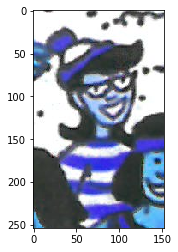

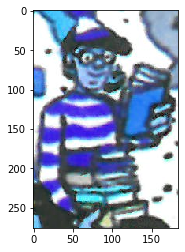

In [14]:
wanda_img = img_0[wanda_row_start:wanda_row_end, wanda_col_start:wanda_col_end]
waldo_img = img_0[3981:4257, 9564:9748]
plt.imshow(wanda_img)
plt.show()
plt.imshow(waldo_img)
plt.show()

In [29]:
range_save_dir = 'D:\\1920Sem1\\CS4243\\project_wx_tryout_code\\range'
range_square_save_dir = 'D:\\1920Sem1\\CS4243\\project_wx_tryout_code\\range_square'
def match_wanda_face(template_original, range_to_match, kernel_size, range_name):
    template = cv2.resize(template_original, (kernel_size, kernel_size))
    
    w, h = template.shape[::-1]
    res = cv2.matchTemplate(range_to_match, template, cv2.TM_CCOEFF_NORMED)
    res_max_value = res[np.unravel_index(np.argmax(res, axis=None), res.shape)]
    print(kernel_size)
    print(range_name + ": " + str(res_max_value))
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    
    range_to_match_copy = range_to_match.copy()
    cv2.rectangle(range_to_match_copy,top_left, bottom_right, 255, 2)
    
    square_cropped = range_to_match_copy[top_left[1]:top_left[1] + h , top_left[0]:top_left[0] + w ]
    imgsquare_name = "square" + "_" + range_name + "_" + str(int(res_max_value*100)) + ".png"

    cv2.imwrite(os.path.join(range_square_save_dir, imgsquare_name), square_cropped)
    imgname = range_name + "_" + str(int(res_max_value*100)) + ".png"
    cv2.imwrite(os.path.join(range_save_dir, imgname), range_to_match_copy)

In [30]:
template_wanda = cv2.imread('template_wanda_1.png', 0)

range_data = df_for_head[:].to_numpy()
for i in range(range_data.shape[0]):
    wanda_row = tuple(range_data[i].astype(int))
    wanda_row_start, wanda_col_start, wanda_row_end, wanda_col_end, wanda_stripe_width = wanda_row

    range1 = img_0[wanda_row_start:wanda_row_end, wanda_col_start:wanda_col_end]
    range1_gray = cv2.cvtColor(range1, cv2.COLOR_BGR2GRAY)

    head_stripe_count = 5 
    kernel_size = (head_stripe_count*wanda_stripe_width // 2) * 2 + 1
    match_wanda_face(template_wanda, range1_gray, kernel_size, "range"+str(i))


55
range0: 0.48604375
65
range1: 0.35227796
65
range2: 0.56162125
71
range3: 0.44371796
81
range4: 0.35795167
101
range5: 0.46733817
31
range6: 0.4407637
131
range7: 0.5335317
25
range8: 0.44992137
55
range9: 0.5584447
221
range10: 0.54434705
35
range11: 0.47676393
185
range12: 0.4202643
55
range13: 0.36421227
91
range14: 0.45308736
31
range15: 0.3031581
61
range16: 0.64739484
95
range17: 0.42110914
115
range18: 0.49598494
115
range19: 0.34777683
35
range20: 0.43317255
15
range21: 0.5185474
55
range22: 0.44515172
15
range23: 0.57971716
15
range24: 0.603687
25
range25: 0.52215666
81
range26: 0.41050258
61
range27: 0.48391992
15
range28: 0.5800777
201
range29: 0.46711734
35
range30: 0.57951576
45
range31: 0.3881121
41
range32: 0.5127799
11
range33: 0.6457666
45
range34: 0.4045002
25
range35: 0.47846487
41
range36: 0.52778524
45
range37: 0.43224013
55
range38: 0.5264191
375
range39: 0.3190318
45
range40: 0.3778156
191
range41: 0.43188265
61
range42: 0.33854493
21
range43: 0.38669005
121
r

In [16]:
from skimage.feature import hog

def hog_d(grey_images_address):
    hog_desc = []
    for img_address in grey_images_address:
        img = cv2.imread(img_address, 0)
        img = cv2.resize(img, (200,200))
        fd = hog(img, orientations=8, pixels_per_cell=(8, 8),
                          cells_per_block=(int(img.shape[0]/100), int(img.shape[1]/100)),
                 transform_sqrt=True, block_norm="L1")
        hog_desc.append(fd)

    return hog_desc

In [33]:
test_images_address = [os.path.join(range_square_save_dir, img) for img in os.listdir(range_square_save_dir) if os.path.isfile(os.path.join(range_square_save_dir, img))]

In [34]:
hog_d_test_imgs = hog_d(test_images_address)

In [35]:
with open ('clf_hog_waldo_wenda.pkl', 'rb') as f:
    clf = pickle.load(f)
    predictions = clf.predict(hog_d_test_imgs)
    indices_waldo = np.where(np.array(predictions)==1)
    print(indices_waldo)

(array([  5,   7,  10,  21,  28,  30,  41,  42,  43,  47,  53,  56,  57,
        69,  78,  86,  89, 104, 110, 118, 127], dtype=int64),)


In [95]:
range_save_dir = 'D:\\1920Sem1\\CS4243\\project_wx_tryout_code\\range'
range_square_save_dir = 'D:\\1920Sem1\\CS4243\\project_wx_tryout_code\\range_square'
template_wanda = cv2.imread('template_wanda_2.png', 0)

def match_wanda_face(template_original, range_to_match, kernel_size, range_name):
    template = cv2.resize(template_original, (kernel_size, kernel_size))
    
    w, h = template.shape[::-1]
    res = cv2.matchTemplate(range_to_match, template, cv2.TM_CCOEFF_NORMED)
    res_max_value = res[np.unravel_index(np.argmax(res, axis=None), res.shape)]
#     print(kernel_size)
#     print(range_name + ": " + str(res_max_value))
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    
    range_to_match_copy = range_to_match.copy()
    
    square_cropped = range_to_match_copy[top_left[1]:top_left[1] + h , top_left[0]:top_left[0] + w ]
    imgsquare_name = "square" + "_" + range_name + "_" + str(int(res_max_value*100)) + ".png"
    cv2.imwrite(os.path.join(range_square_save_dir, imgsquare_name), square_cropped)

    cv2.rectangle(range_to_match_copy,top_left, bottom_right, 255, 2)   
    imgname = range_name + "_" + str(int(res_max_value*100)) + ".png"
    cv2.imwrite(os.path.join(range_save_dir, imgname), range_to_match_copy)

In [114]:
num = 39
img_0 = cv2.imread(images[num])

red_white_mask_rot = preprocess_input_img(img_0)

start_time = time.time()
result  = np.apply_along_axis(get_suspected_waldo_stripe_region_for_col, 1, red_white_mask_rot)
stop_time = time.time()
print("--- %s seconds ---" % (stop_time - start_time))

start_time = time.time()
raw_stripe_confidence_regions_df = get_raw_stripe_confidence_regions_df_from_suspected_stripe_regions(result)
combined_stripe_confidence_regions_df = get_combined_stripe_confidence_regions_df_from_raw_stripe_confidence_regions_df(raw_stripe_confidence_regions_df)
stop_time = time.time()
print("--- %s seconds ---" % (stop_time - start_time))
print(combined_stripe_confidence_regions_df[:].to_numpy().shape)

df_for_rectangles = combined_stripe_confidence_regions_df.copy()

df_for_head = df_for_rectangles[['row_confidence_interval_start', 'col_confidence_interval_start', 'row_confidence_interval_end', 'col_confidence_interval_end']].copy()
df_for_head['stripe_width'] = (df_for_head['col_confidence_interval_end'] - df_for_head['col_confidence_interval_start'])/8

# to expand the body bbox horizontally a bit and extend the body bbox upwards to bound the head
df_for_head['col_confidence_interval_start'] = np.where(df_for_head['col_confidence_interval_start'] - 2*df_for_head['stripe_width']<0, 0, df_for_head['col_confidence_interval_start'] - 2*df_for_head['stripe_width'])
df_for_head['col_confidence_interval_end'] = np.where(df_for_head['col_confidence_interval_end'] + 2*df_for_head['stripe_width']>img_0.shape[1]-1, img_0.shape[1]-1, df_for_head['col_confidence_interval_end'] + 2*df_for_head['stripe_width'])
df_for_head['row_confidence_interval_start'] = np.where(df_for_head['row_confidence_interval_start'] - 10*df_for_head['stripe_width']<0, 0, df_for_head['row_confidence_interval_start'] - 10*df_for_head['stripe_width'])


range_data = df_for_head[:].to_numpy()
for i in range(range_data.shape[0]):
    wanda_row = tuple(range_data[i].astype(int))
    wanda_row_start, wanda_col_start, wanda_row_end, wanda_col_end, wanda_stripe_width = wanda_row

    range1 = img_0[wanda_row_start:wanda_row_end, wanda_col_start:wanda_col_end]
    range1_gray = cv2.cvtColor(range1, cv2.COLOR_BGR2GRAY)

    head_stripe_count = 5 
    kernel_size = (head_stripe_count*wanda_stripe_width // 2) * 2 + 1
    match_wanda_face(template_wanda, range1_gray, kernel_size, str(num) + "_range"+str(i))

--- 68.38724279403687 seconds ---
--- 12.269042253494263 seconds ---
(348, 7)
